In [1]:
import polars as pl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import numpy as np

df = pl.read_csv("./DSU-Dataset.csv")
col = df["Date"].str.to_date()
df = df.with_columns(col)

df.head()

Site,Date,Hour,REASON_VISIT_NAME,ED Enc,ED Enc Admitted
str,date,f64,str,i64,i64
"""A""",2018-01-01,0.0,"""BREATHING PROBLEM""",1,1
"""A""",2018-01-01,0.0,"""BURN""",1,0
"""A""",2018-01-01,0.0,"""SHAKING""",1,1
"""A""",2018-01-01,0.0,"""VOMITING""",1,0
"""A""",2018-01-01,1.0,"""FROSTBITE""",1,0


In [35]:
df_datetime = df.with_columns(
    pl.datetime(
        pl.col("Date").dt.year(),
        pl.col("Date").dt.month(),
        pl.col("Date").dt.day(),
        pl.col("Hour")
    ).alias("Date")
).group_by(["Site", "Date"]).agg(pl.col("ED Enc").sum(), pl.col("ED Enc Admitted").sum()).sort(["Site", "Date"])

# no covid
df_datetime = df_datetime.filter(pl.col("Date").dt.year != 2020).filter(pl.col("Date").dt.year != 2021)
# no outliers
df_datetime = df_datetime.group_by(["Site", "Date"]).agg(
        pl.col("ED Enc").sum().alias("ED Enc"), pl.col("ED Enc Admitted").sum().alias("ED Enc Admitted")
        ).with_columns(
        pl.when(
            np.abs(pl.col("ED Enc") - pl.col("ED Enc").mean() / pl.col("ED Enc").std()) > 3
        ).then(pl.col("ED Enc").median()).otherwise(pl.col("ED Enc")),
        pl.when(
            np.abs(pl.col("ED Enc Admitted") - pl.col("ED Enc Admitted").mean() / pl.col("ED Enc Admitted").std()) > 3
        ).then(pl.col("ED Enc Admitted").median()).otherwise(pl.col("ED Enc Admitted"))
    ).sort(["Site", "Date"])

# now sum into hourly blocks
df_hourly_blocks = df_datetime.group_by_dynamic("Date", every="6h", closed="left", group_by="Site").agg(pl.col("ED Enc").sum(), pl.col("ED Enc Admitted").sum()).sort(["Site", "Date"])

# pandas for arima
df_hourly_blocks_pandas = df_hourly_blocks.to_pandas().set_index("Date")
df_hourly_blocks_pandas

,Site,ED Enc,ED Enc Admitted
Date,,,
2018-01-01 00:00:00,A,16.0,6.0
2018-01-01 06:00:00,A,19.0,8.0
2018-01-01 12:00:00,A,24.0,10.0
2018-01-01 18:00:00,A,21.0,10.0
2018-01-02 00:00:00,A,17.0,5.0
...,...,...,...
2025-08-30 18:00:00,D,15.0,3.0
2025-08-31 00:00:00,D,6.0,2.0
2025-08-31 06:00:00,D,16.0,3.0


In [54]:
from datetime import date
postCOVID = df_hourly_blocks.filter(pl.col("Date") > pl.lit(date(2021, 2, 1)))
postCOVID_df = postCOVID.with_columns(
    pl.col("Date").dt.year().alias("Year"),
    pl.col("Date").dt.month().alias("Month"),
    pl.col("Date").dt.day().alias("Day"),
    pl.col("Date").dt.hour().alias("Hour"),
    pl.col("Date").dt.weekday().alias("Weekday")
).drop("Date").select(["Site", "Year", "Month", "Day", "Hour", "Weekday", "ED Enc", "ED Enc Admitted"])

postCOVID_df

Site,Year,Month,Day,Hour,Weekday,ED Enc,ED Enc Admitted
str,i32,i8,i8,i8,i8,f64,f64
"""A""",2021,2,1,6,1,22.0,6.0
"""A""",2021,2,1,12,1,22.0,7.0
"""A""",2021,2,1,18,1,22.0,9.0
"""A""",2021,2,2,0,2,10.0,2.0
"""A""",2021,2,2,6,2,20.0,12.0
…,…,…,…,…,…,…,…
"""D""",2025,8,30,18,6,15.0,3.0
"""D""",2025,8,31,0,7,6.0,2.0
"""D""",2025,8,31,6,7,16.0,3.0


In [52]:
hourly_blocks_df = df_hourly_blocks.with_columns(
    pl.col("Date").dt.year().alias("Year"),
    pl.col("Date").dt.month().alias("Month"),
    pl.col("Date").dt.day().alias("Day"),
    pl.col("Date").dt.hour().alias("Hour"),
    pl.col("Date").dt.weekday().alias("Weekday")
).drop("Date").select(["Site", "Year", "Month", "Day", "Hour", "Weekday", "ED Enc", "ED Enc Admitted"])
hourly_blocks_df

Site,Year,Month,Day,Hour,Weekday,ED Enc,ED Enc Admitted
str,i32,i8,i8,i8,i8,f64,f64
"""A""",2018,1,1,0,1,16.0,6.0
"""A""",2018,1,1,6,1,19.0,8.0
"""A""",2018,1,1,12,1,24.0,10.0
"""A""",2018,1,1,18,1,21.0,10.0
"""A""",2018,1,2,0,2,17.0,5.0
…,…,…,…,…,…,…,…
"""D""",2025,8,30,18,6,15.0,3.0
"""D""",2025,8,31,0,7,6.0,2.0
"""D""",2025,8,31,6,7,16.0,3.0


# Site A Random Forest Model

In [56]:
siteA_train = postCOVID_df.filter(pl.col("Site") == "A")
siteA_X = siteA_train.select(["Year", "Month", "Day", "Weekday", "Hour"])
siteA_Y = siteA_train.select(["ED Enc", "ED Enc Admitted"])
siteA_X_train, siteA_X_test, siteA_Y_train, siteA_Y_test = train_test_split(siteA_X, siteA_Y, test_size=0.2, random_state=42)
siteA_model = RandomForestRegressor().fit(siteA_X_train, siteA_Y_train)

In [46]:
print(f"R² score of {siteA_model.score(siteA_X_test, siteA_Y_test)}")

R² score of 0.517572425050318


In [125]:
from datetime import datetime, timedelta
# predict and end two months after the dataset has ended
predict_date_range = pl.datetime_range(
    start=pl.lit(date(2021, 2, 1)),
    end=datetime.combine((df["Date"].max() + timedelta(days=60)), datetime.min.time()) + timedelta(hours=23, minutes=59),
    interval=timedelta(hours=6),
    eager=True
)
predict_dates = pl.DataFrame(predict_date_range).with_columns(
    pl.col("literal").dt.year().alias("Year"),
    pl.col("literal").dt.month().alias("Month"),
    pl.col("literal").dt.day().alias("Day"),
    pl.col("literal").dt.weekday().alias("Weekday"),
    pl.col("literal").dt.hour().alias("Hour"),
).drop("literal")
predict_dates

Year,Month,Day,Weekday,Hour
i32,i8,i8,i8,i8
2021,2,1,1,0
2021,2,1,1,6
2021,2,1,1,12
2021,2,1,1,18
2021,2,2,2,0
…,…,…,…,…
2025,10,29,3,18
2025,10,30,4,0
2025,10,30,4,6


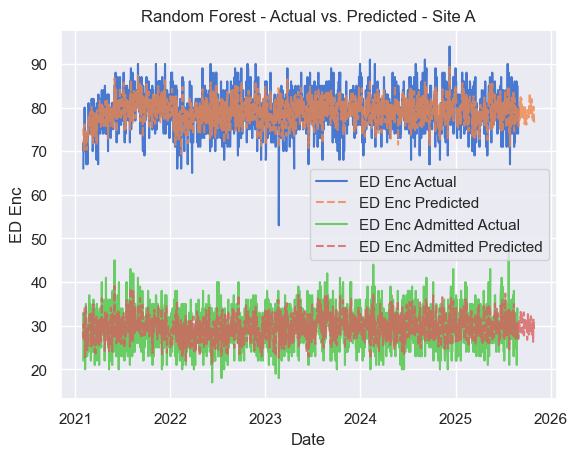

In [126]:
sns.set_theme(style="darkgrid", palette="muted")
siteA_real = postCOVID_df.filter(pl.col("Site") == "A")
siteA_real_X = siteA_real.select(["Year", "Month", "Day", "Weekday", "Hour"])
    
plot_df = siteA_real.with_columns(
    pl.datetime(
        pl.col("Year"),
        pl.col("Month"),
        pl.col("Day"),
    ).alias("Date")
).group_by("Date").agg(pl.col("ED Enc").sum(), pl.col("ED Enc Admitted").sum())

predict = siteA_model.predict(predict_dates)
predict_df = predict_dates.with_columns(
    pl.Series(name="ED Enc Predicted", values=predict[:,0]),
    pl.Series(name="ED Enc Admitted Predicted", values=predict[:,1])
).with_columns(
    pl.datetime(
        pl.col("Year"),
        pl.col("Month"),
        pl.col("Day"),
    ).alias("Date")
).group_by("Date").agg(pl.col("ED Enc Predicted").sum(), pl.col("ED Enc Admitted Predicted").sum())

sns.lineplot(data=plot_df, x="Date", y="ED Enc", label="ED Enc Actual")
sns.lineplot(data=predict_df, x="Date", y="ED Enc Predicted", label="ED Enc Predicted", linestyle="--", alpha=0.8)
sns.lineplot(data=plot_df, x="Date", y="ED Enc Admitted", label="ED Enc Admitted Actual")
ax = sns.lineplot(data=predict_df, x="Date", y="ED Enc Admitted Predicted", label="ED Enc Admitted Predicted", linestyle="--", alpha=0.8)
ax.set_title("Random Forest - Actual vs. Predicted - Site A")

plt.show()

# Site B Random Forest Model

In [127]:
siteB_train = postCOVID_df.filter(pl.col("Site") == "B")
siteB_X = siteB_train.select(["Year", "Month", "Day", "Weekday", "Hour"])
siteB_Y = siteB_train.select(["ED Enc", "ED Enc Admitted"])
siteB_X_train, siteB_X_test, siteB_Y_train, siteB_Y_test = train_test_split(siteB_X, siteB_Y, test_size=0.2, random_state=42)
siteB_model = RandomForestRegressor().fit(siteB_X_train, siteB_Y_train)

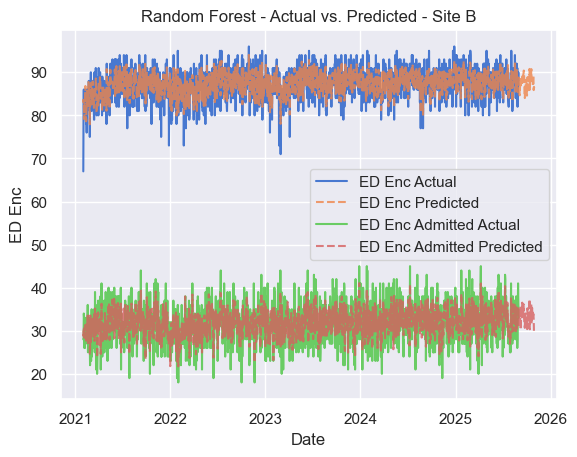

In [128]:
siteB_real = postCOVID_df.filter(pl.col("Site") == "B")
siteB_real_X = siteB_real.select(["Year", "Month", "Day", "Weekday", "Hour"])

plot_df = siteB_real.with_columns(
    pl.datetime(
        pl.col("Year"),
        pl.col("Month"),
        pl.col("Day"),
    ).alias("Date")
).group_by("Date").agg(pl.col("ED Enc").sum(), pl.col("ED Enc Admitted").sum())

predict = siteB_model.predict(predict_dates)
predict_df = predict_dates.with_columns(
    pl.Series(name="ED Enc Predicted", values=predict[:,0]),
    pl.Series(name="ED Enc Admitted Predicted", values=predict[:,1])
).with_columns(
    pl.datetime(
        pl.col("Year"),
        pl.col("Month"),
        pl.col("Day"),
    ).alias("Date")
).group_by("Date").agg(pl.col("ED Enc Predicted").sum(), pl.col("ED Enc Admitted Predicted").sum())

sns.lineplot(data=plot_df, x="Date", y="ED Enc", label="ED Enc Actual")
sns.lineplot(data=predict_df, x="Date", y="ED Enc Predicted", label="ED Enc Predicted", linestyle="--", alpha=0.8)
sns.lineplot(data=plot_df, x="Date", y="ED Enc Admitted", label="ED Enc Admitted Actual")
ax = sns.lineplot(data=predict_df, x="Date", y="ED Enc Admitted Predicted", label="ED Enc Admitted Predicted", linestyle="--", alpha=0.8)
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
ax.set_title("Random Forest - Actual vs. Predicted - Site B")
plt.show()

In [129]:
print(f"R² score of {siteB_model.score(siteB_X_test, siteB_Y_test)}")

R² score of 0.47304338252122424


# Site C Random Forest Model

In [130]:
siteC_train = postCOVID_df.filter(pl.col("Site") == "C")
siteC_X = siteC_train.select(["Year", "Month", "Day", "Weekday", "Hour"])
siteC_Y = siteC_train.select(["ED Enc", "ED Enc Admitted"])
siteC_X_train, siteC_X_test, siteC_Y_train, siteC_Y_test = train_test_split(siteC_X, siteC_Y, test_size=0.2, random_state=42)
siteC_model = RandomForestRegressor().fit(siteC_X_train, siteC_Y_train)

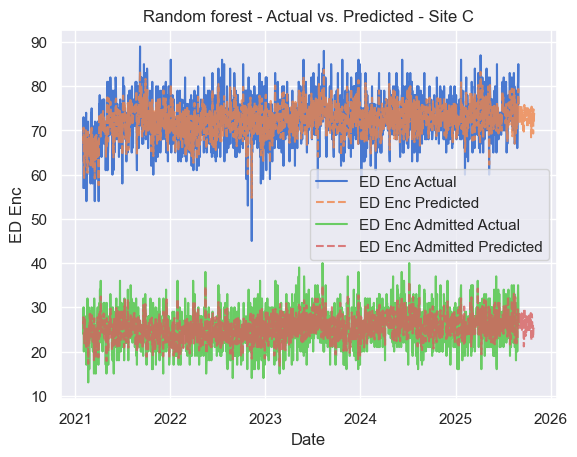

In [131]:
siteC_real = postCOVID_df.filter(pl.col("Site") == "C")
siteC_real_X = siteC_real.select(["Year", "Month", "Day", "Weekday", "Hour"])

plot_df = siteC_real.with_columns(
    pl.datetime(
        pl.col("Year"),
        pl.col("Month"),
        pl.col("Day"),
    ).alias("Date")
).group_by("Date").agg(pl.col("ED Enc").sum(), pl.col("ED Enc Admitted").sum())

predict = siteC_model.predict(predict_dates)
predict_df = predict_dates.with_columns(
    pl.Series(name="ED Enc Predicted", values=predict[:,0]),
    pl.Series(name="ED Enc Admitted Predicted", values=predict[:,1])
).with_columns(
    pl.datetime(
        pl.col("Year"),
        pl.col("Month"),
        pl.col("Day"),
    ).alias("Date")
).group_by("Date").agg(pl.col("ED Enc Predicted").sum(), pl.col("ED Enc Admitted Predicted").sum())

sns.lineplot(data=plot_df, x="Date", y="ED Enc", label="ED Enc Actual")
sns.lineplot(data=predict_df, x="Date", y="ED Enc Predicted", label="ED Enc Predicted", linestyle="--", alpha=0.8)
sns.lineplot(data=plot_df, x="Date", y="ED Enc Admitted", label="ED Enc Admitted Actual")
ax = sns.lineplot(data=predict_df, x="Date", y="ED Enc Admitted Predicted", label="ED Enc Admitted Predicted", linestyle="--", alpha=0.8)

ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
ax.set_title("Random forest - Actual vs. Predicted - Site C")
plt.show()

In [132]:
print(f"R² score of {siteC_model.score(siteC_X_test, siteC_Y_test)}")

R² score of 0.5891748184168064


# Site D Random Forest Model

In [133]:
siteD_train = postCOVID_df.filter(pl.col("Site") == "D")
siteD_X = siteD_train.select(["Year", "Month", "Day", "Weekday", "Hour"])
siteD_Y = siteD_train.select(["ED Enc", "ED Enc Admitted"])
siteD_X_train, siteD_X_test, siteD_Y_train, siteD_Y_test = train_test_split(siteD_X, siteD_Y, test_size=0.2, random_state=42)
siteD_model = RandomForestRegressor().fit(siteD_X_train, siteD_Y_train)

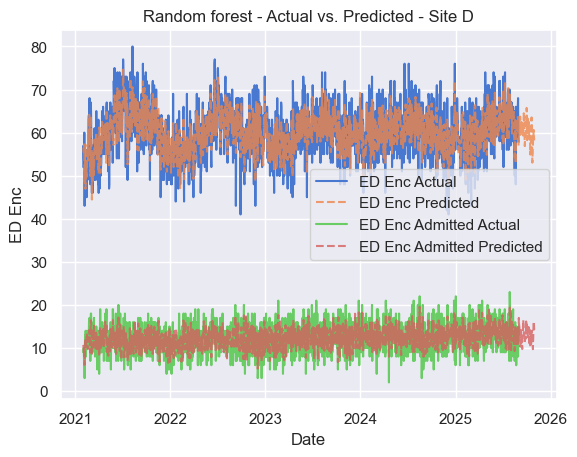

In [134]:
siteD_real = postCOVID_df.filter(pl.col("Site") == "D")
siteD_real_X = siteD_real.select(["Year", "Month", "Day", "Weekday", "Hour"])

plot_df = siteD_real.with_columns(
    pl.datetime(
        pl.col("Year"),
        pl.col("Month"),
        pl.col("Day"),
    ).alias("Date")
).group_by("Date").agg(pl.col("ED Enc").sum(), pl.col("ED Enc Admitted").sum())

predict = siteD_model.predict(predict_dates)
predict_df = predict_dates.with_columns(
    pl.Series(name="ED Enc Predicted", values=predict[:,0]),
    pl.Series(name="ED Enc Admitted Predicted", values=predict[:,1])
).with_columns(
    pl.datetime(
        pl.col("Year"),
        pl.col("Month"),
        pl.col("Day"),
    ).alias("Date")
).group_by("Date").agg(pl.col("ED Enc Predicted").sum(), pl.col("ED Enc Admitted Predicted").sum())

sns.lineplot(data=plot_df, x="Date", y="ED Enc", label="ED Enc Actual")
sns.lineplot(data=predict_df, x="Date", y="ED Enc Predicted", label="ED Enc Predicted", linestyle="--", alpha=0.8)
sns.lineplot(data=plot_df, x="Date", y="ED Enc Admitted", label="ED Enc Admitted Actual")
ax = sns.lineplot(data=predict_df, x="Date", y="ED Enc Admitted Predicted", label="ED Enc Admitted Predicted", linestyle="--", alpha=0.8)

ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
ax.set_title("Random forest - Actual vs. Predicted - Site D")
plt.show()

In [135]:
print(f"R² score of {siteD_model.score(siteD_X_test, siteD_Y_test)}")

R² score of 0.49825964831269925


# Linear regression?

## Site A 

In [136]:
from sklearn.linear_model import LinearRegression, Ridge

siteA_linreg = Ridge(alpha=1).fit(siteA_X_train, siteA_Y_train)
score = siteA_linreg.score(siteA_X_test, siteA_Y_test)
print(f"Ridge Regression R² score of {score}")

Ridge Regression R² score of 0.4259942174600071


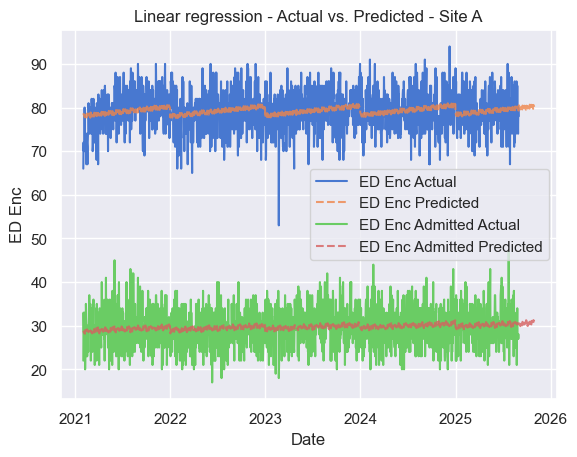

In [137]:
plot_df = siteA_real.with_columns(
    pl.datetime(
        pl.col("Year"),
        pl.col("Month"),
        pl.col("Day"),
    ).alias("Date")
).group_by("Date").agg(pl.col("ED Enc").sum(), pl.col("ED Enc Admitted").sum())

predict = siteA_linreg.predict(predict_dates)
predict_df = predict_dates.with_columns(
    pl.Series(name="ED Enc Predicted", values=predict[:,0]),
    pl.Series(name="ED Enc Admitted Predicted", values=predict[:,1])
).with_columns(
    pl.datetime(
        pl.col("Year"),
        pl.col("Month"),
        pl.col("Day"),
    ).alias("Date")
).group_by("Date").agg(pl.col("ED Enc Predicted").sum(), pl.col("ED Enc Admitted Predicted").sum())

sns.lineplot(data=plot_df, x="Date", y="ED Enc", label="ED Enc Actual")
sns.lineplot(data=predict_df, x="Date", y="ED Enc Predicted", label="ED Enc Predicted", linestyle="--", alpha=0.8)
sns.lineplot(data=plot_df, x="Date", y="ED Enc Admitted", label="ED Enc Admitted Actual")
ax = sns.lineplot(data=predict_df, x="Date", y="ED Enc Admitted Predicted", label="ED Enc Admitted Predicted", linestyle="--", alpha=0.8)

ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
ax.set_title("Linear regression - Actual vs. Predicted - Site A")
plt.show()

## Site B

In [138]:
siteB_linreg = Ridge().fit(siteB_X_train, siteB_Y_train)
print(f"R² score of {siteB_linreg.score(siteB_X_test, siteB_Y_test)}")

R² score of 0.4047366368430475


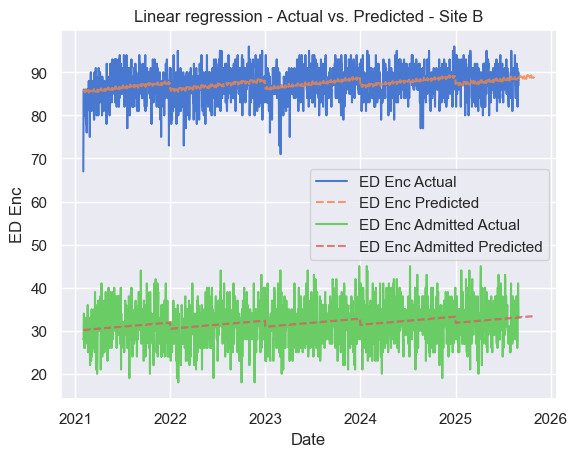

In [139]:
plot_df = siteB_real.with_columns(
    pl.datetime(
        pl.col("Year"),
        pl.col("Month"),
        pl.col("Day"),
    ).alias("Date")
).group_by("Date").agg(pl.col("ED Enc").sum(), pl.col("ED Enc Admitted").sum())

predict = siteB_linreg.predict(predict_dates)
predict_df = predict_dates.with_columns(
    pl.Series(name="ED Enc Predicted", values=predict[:,0]),
    pl.Series(name="ED Enc Admitted Predicted", values=predict[:,1])
).with_columns(
    pl.datetime(
        pl.col("Year"),
        pl.col("Month"),
        pl.col("Day"),
    ).alias("Date")
).group_by("Date").agg(pl.col("ED Enc Predicted").sum(), pl.col("ED Enc Admitted Predicted").sum())

sns.lineplot(data=plot_df, x="Date", y="ED Enc", label="ED Enc Actual")
sns.lineplot(data=predict_df, x="Date", y="ED Enc Predicted", label="ED Enc Predicted", linestyle="--", alpha=0.8)
sns.lineplot(data=plot_df, x="Date", y="ED Enc Admitted", label="ED Enc Admitted Actual")
ax = sns.lineplot(data=predict_df, x="Date", y="ED Enc Admitted Predicted", label="ED Enc Admitted Predicted", linestyle="--", alpha=0.8)

ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
ax.set_title("Linear regression - Actual vs. Predicted - Site B")
plt.show()

## Site C

In [140]:
siteC_linreg = LinearRegression().fit(siteC_X_train, siteC_Y_train)
print(f"R² score of {siteC_linreg.score(siteC_X_test, siteC_Y_test)}")

R² score of 0.44383854408118


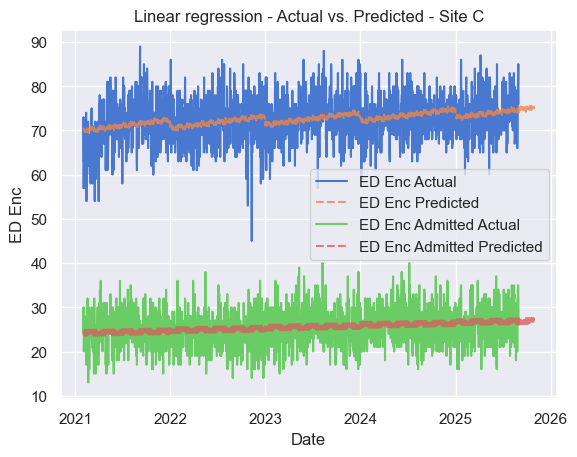

In [141]:
plot_df = siteC_real.with_columns(
    pl.datetime(
        pl.col("Year"),
        pl.col("Month"),
        pl.col("Day"),
    ).alias("Date")
).group_by("Date").agg(pl.col("ED Enc").sum(), pl.col("ED Enc Admitted").sum())

predict = siteC_linreg.predict(predict_dates)
predict_df = predict_dates.with_columns(
    pl.Series(name="ED Enc Predicted", values=predict[:,0]),
    pl.Series(name="ED Enc Admitted Predicted", values=predict[:,1])
).with_columns(
    pl.datetime(
        pl.col("Year"),
        pl.col("Month"),
        pl.col("Day"),
    ).alias("Date")
).group_by("Date").agg(pl.col("ED Enc Predicted").sum(), pl.col("ED Enc Admitted Predicted").sum())

sns.lineplot(data=plot_df, x="Date", y="ED Enc", label="ED Enc Actual")
sns.lineplot(data=predict_df, x="Date", y="ED Enc Predicted", label="ED Enc Predicted", linestyle="--", alpha=0.8)
sns.lineplot(data=plot_df, x="Date", y="ED Enc Admitted", label="ED Enc Admitted Actual")
ax = sns.lineplot(data=predict_df, x="Date", y="ED Enc Admitted Predicted", label="ED Enc Admitted Predicted", linestyle="--", alpha=0.8)

ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
ax.set_title("Linear regression - Actual vs. Predicted - Site C")
plt.show()

## Site D

In [142]:
siteD_linreg = LinearRegression().fit(siteD_X_train, siteD_Y_train)
print(f"R² score of {siteD_linreg.score(siteD_X_test, siteD_Y_test)}")

R² score of 0.31685411220123355


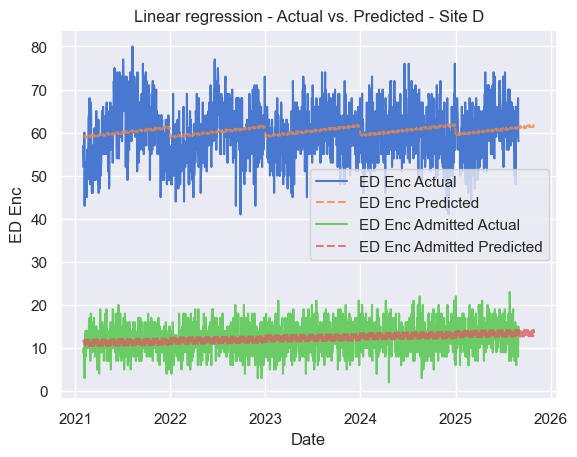

In [143]:
plot_df = siteD_real.with_columns(
    pl.datetime(
        pl.col("Year"),
        pl.col("Month"),
        pl.col("Day"),
    ).alias("Date")
).group_by("Date").agg(pl.col("ED Enc").sum(), pl.col("ED Enc Admitted").sum())

predict = siteD_linreg.predict(predict_dates)
predict_df = predict_dates.with_columns(
    pl.Series(name="ED Enc Predicted", values=predict[:,0]),
    pl.Series(name="ED Enc Admitted Predicted", values=predict[:,1])
).with_columns(
    pl.datetime(
        pl.col("Year"),
        pl.col("Month"),
        pl.col("Day"),
    ).alias("Date")
).group_by("Date").agg(pl.col("ED Enc Predicted").sum(), pl.col("ED Enc Admitted Predicted").sum())

sns.lineplot(data=plot_df, x="Date", y="ED Enc", label="ED Enc Actual")
sns.lineplot(data=predict_df, x="Date", y="ED Enc Predicted", label="ED Enc Predicted", linestyle="--", alpha=0.8)
sns.lineplot(data=plot_df, x="Date", y="ED Enc Admitted", label="ED Enc Admitted Actual")
ax = sns.lineplot(data=predict_df, x="Date", y="ED Enc Admitted Predicted", label="ED Enc Admitted Predicted", linestyle="--", alpha=0.8)

ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
ax.set_title("Linear regression - Actual vs. Predicted - Site D")
plt.show()

# CATboost?
Gradient boosted trees

In [144]:
from catboost import CatBoostRegressor, Pool
siteA_train_pool = Pool(siteA_X_train.to_pandas(), siteA_Y_train.to_pandas(), cat_features=siteA_X.columns)
siteA_test_pool = Pool(siteA_X_test.to_pandas(), siteA_Y_test.to_pandas(), cat_features=siteA_X.columns)

siteA_catmodel = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, loss_function="MultiRMSE")
siteA_catmodel.fit(siteA_train_pool)

print(f"R² score of {siteA_catmodel.score(siteA_test_pool)}")

0:	learn: 4.8888997	total: 37.2ms	remaining: 37.1s
1:	learn: 4.6103783	total: 64.3ms	remaining: 32.1s
2:	learn: 4.3678564	total: 93ms	remaining: 30.9s
3:	learn: 4.1582810	total: 133ms	remaining: 33.2s
4:	learn: 3.9834359	total: 167ms	remaining: 33.1s
5:	learn: 3.8323234	total: 201ms	remaining: 33.3s
6:	learn: 3.7082978	total: 227ms	remaining: 32.2s
7:	learn: 3.6045480	total: 266ms	remaining: 33s
8:	learn: 3.5183754	total: 288ms	remaining: 31.7s
9:	learn: 3.4484747	total: 344ms	remaining: 34s
10:	learn: 3.3855697	total: 398ms	remaining: 35.8s
11:	learn: 3.3373010	total: 444ms	remaining: 36.6s
12:	learn: 3.2960888	total: 473ms	remaining: 35.9s
13:	learn: 3.2598443	total: 518ms	remaining: 36.5s
14:	learn: 3.2320715	total: 548ms	remaining: 36s
15:	learn: 3.2103166	total: 574ms	remaining: 35.3s
16:	learn: 3.1902958	total: 612ms	remaining: 35.4s
17:	learn: 3.1736413	total: 650ms	remaining: 35.5s
18:	learn: 3.1588078	total: 688ms	remaining: 35.5s
19:	learn: 3.1482382	total: 709ms	remaining: 3

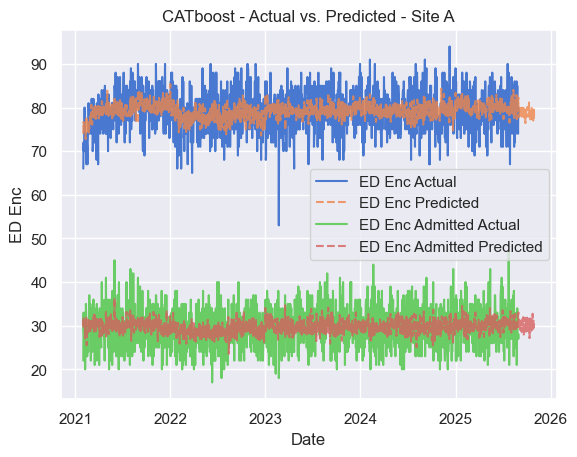

In [145]:
plot_df = siteA_real.with_columns(
    pl.datetime(
        pl.col("Year"),
        pl.col("Month"),
        pl.col("Day"),
    ).alias("Date")
).group_by("Date").agg(pl.col("ED Enc").sum(), pl.col("ED Enc Admitted").sum())

predict = siteA_catmodel.predict(predict_dates.to_pandas())
predict_df = predict_dates.with_columns(
    pl.Series(name="ED Enc Predicted", values=predict[:,0]),
    pl.Series(name="ED Enc Admitted Predicted", values=predict[:,1])
).with_columns(
    pl.datetime(
        pl.col("Year"),
        pl.col("Month"),
        pl.col("Day"),
    ).alias("Date")
).group_by("Date").agg(pl.col("ED Enc Predicted").sum(), pl.col("ED Enc Admitted Predicted").sum())

sns.lineplot(data=plot_df, x="Date", y="ED Enc", label="ED Enc Actual")
sns.lineplot(data=predict_df, x="Date", y="ED Enc Predicted", label="ED Enc Predicted", linestyle="--", alpha=0.8)
sns.lineplot(data=plot_df, x="Date", y="ED Enc Admitted", label="ED Enc Admitted Actual")
ax = sns.lineplot(data=predict_df, x="Date", y="ED Enc Admitted Predicted", label="ED Enc Admitted Predicted", linestyle="--", alpha=0.8)

ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
ax.set_title("CATboost - Actual vs. Predicted - Site A")
plt.show()

In [146]:
siteB_train_pool = Pool(siteB_X_train.to_pandas(), siteB_Y_train.to_pandas(), cat_features=siteB_X.columns)
siteB_test_pool = Pool(siteB_X_test.to_pandas(), siteB_Y_test.to_pandas(), cat_features=siteB_X.columns)

siteB_catmodel = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, loss_function="MultiRMSE")
siteB_catmodel.fit(siteB_train_pool)

print(f"R² score of {siteB_catmodel.score(siteB_test_pool)}")

0:	learn: 3.9147580	total: 46.7ms	remaining: 46.6s
1:	learn: 3.7464482	total: 69ms	remaining: 34.4s
2:	learn: 3.6021770	total: 110ms	remaining: 36.6s
3:	learn: 3.4820770	total: 140ms	remaining: 34.8s
4:	learn: 3.3826285	total: 191ms	remaining: 38s
5:	learn: 3.2972005	total: 227ms	remaining: 37.7s
6:	learn: 3.2254924	total: 264ms	remaining: 37.5s
7:	learn: 3.1668428	total: 290ms	remaining: 35.9s
8:	learn: 3.1222953	total: 310ms	remaining: 34.1s
9:	learn: 3.0821892	total: 332ms	remaining: 32.9s
10:	learn: 3.0482096	total: 391ms	remaining: 35.1s
11:	learn: 3.0247018	total: 409ms	remaining: 33.7s
12:	learn: 3.0007102	total: 444ms	remaining: 33.7s
13:	learn: 2.9808487	total: 480ms	remaining: 33.8s
14:	learn: 2.9647256	total: 530ms	remaining: 34.8s
15:	learn: 2.9494395	total: 572ms	remaining: 35.2s
16:	learn: 2.9385231	total: 596ms	remaining: 34.4s
17:	learn: 2.9293018	total: 653ms	remaining: 35.6s
18:	learn: 2.9224936	total: 675ms	remaining: 34.9s
19:	learn: 2.9151324	total: 734ms	remaining

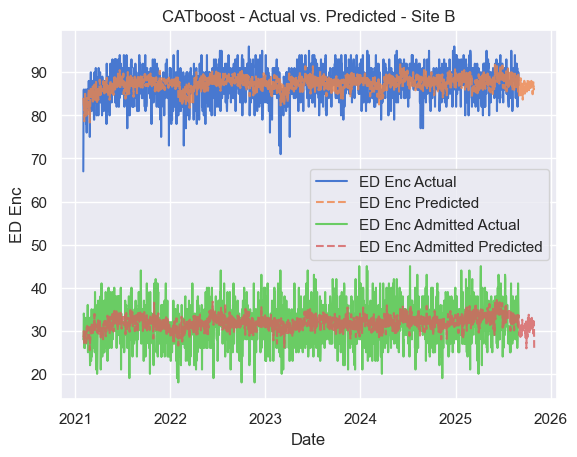

In [147]:
plot_df = siteB_real.with_columns(
    pl.datetime(
        pl.col("Year"),
        pl.col("Month"),
        pl.col("Day"),
    ).alias("Date")
).group_by("Date").agg(pl.col("ED Enc").sum(), pl.col("ED Enc Admitted").sum())

predict = siteB_catmodel.predict(predict_dates.to_pandas())
predict_df = predict_dates.with_columns(
    pl.Series(name="ED Enc Predicted", values=predict[:,0]),
    pl.Series(name="ED Enc Admitted Predicted", values=predict[:,1])
).with_columns(
    pl.datetime(
        pl.col("Year"),
        pl.col("Month"),
        pl.col("Day"),
    ).alias("Date")
).group_by("Date").agg(pl.col("ED Enc Predicted").sum(), pl.col("ED Enc Admitted Predicted").sum())

sns.lineplot(data=plot_df, x="Date", y="ED Enc", label="ED Enc Actual")
sns.lineplot(data=predict_df, x="Date", y="ED Enc Predicted", label="ED Enc Predicted", linestyle="--", alpha=0.8)
sns.lineplot(data=plot_df, x="Date", y="ED Enc Admitted", label="ED Enc Admitted Actual")
ax = sns.lineplot(data=predict_df, x="Date", y="ED Enc Admitted Predicted", label="ED Enc Admitted Predicted", linestyle="--", alpha=0.8)

ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
ax.set_title("CATboost - Actual vs. Predicted - Site B")
plt.show()

In [148]:
siteC_train_pool = Pool(siteC_X_train.to_pandas(), siteC_Y_train.to_pandas(), cat_features=siteC_X.columns)
siteC_test_pool = Pool(siteC_X_test.to_pandas(), siteC_Y_test.to_pandas(), cat_features=siteC_X.columns)

siteC_catmodel = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, loss_function="MultiRMSE")
siteC_catmodel.fit(siteC_train_pool)

print(f"R² score of {siteC_catmodel.score(siteC_test_pool)}")

0:	learn: 5.5221365	total: 45.6ms	remaining: 45.5s
1:	learn: 5.1817824	total: 74.4ms	remaining: 37.1s
2:	learn: 4.9038620	total: 118ms	remaining: 39.4s
3:	learn: 4.6809613	total: 145ms	remaining: 36.2s
4:	learn: 4.4591791	total: 178ms	remaining: 35.4s
5:	learn: 4.2806569	total: 222ms	remaining: 36.8s
6:	learn: 4.1199739	total: 256ms	remaining: 36.3s
7:	learn: 3.9840568	total: 293ms	remaining: 36.4s
8:	learn: 3.8772186	total: 333ms	remaining: 36.7s
9:	learn: 3.7797610	total: 373ms	remaining: 36.9s
10:	learn: 3.7009196	total: 413ms	remaining: 37.1s
11:	learn: 3.6376603	total: 447ms	remaining: 36.8s
12:	learn: 3.5870405	total: 466ms	remaining: 35.4s
13:	learn: 3.5406796	total: 511ms	remaining: 36s
14:	learn: 3.5019276	total: 556ms	remaining: 36.5s
15:	learn: 3.4794709	total: 575ms	remaining: 35.3s
16:	learn: 3.4590028	total: 590ms	remaining: 34.1s
17:	learn: 3.4415244	total: 604ms	remaining: 33s
18:	learn: 3.4214900	total: 647ms	remaining: 33.4s
19:	learn: 3.4042037	total: 689ms	remaining

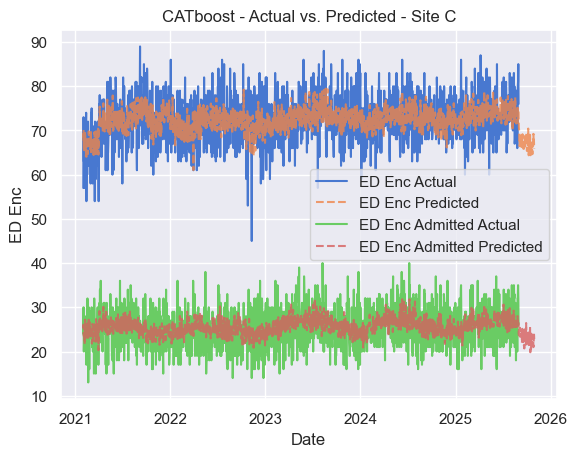

In [149]:
plot_df = siteC_real.with_columns(
    pl.datetime(
        pl.col("Year"),
        pl.col("Month"),
        pl.col("Day"),
    ).alias("Date")
).group_by("Date").agg(pl.col("ED Enc").sum(), pl.col("ED Enc Admitted").sum())

predict = siteC_catmodel.predict(predict_dates.to_pandas())
predict_df = predict_dates.with_columns(
    pl.Series(name="ED Enc Predicted", values=predict[:,0]),
    pl.Series(name="ED Enc Admitted Predicted", values=predict[:,1])
).with_columns(
    pl.datetime(
        pl.col("Year"),
        pl.col("Month"),
        pl.col("Day"),
    ).alias("Date")
).group_by("Date").agg(pl.col("ED Enc Predicted").sum(), pl.col("ED Enc Admitted Predicted").sum())

sns.lineplot(data=plot_df, x="Date", y="ED Enc", label="ED Enc Actual")
sns.lineplot(data=predict_df, x="Date", y="ED Enc Predicted", label="ED Enc Predicted", linestyle="--", alpha=0.8)
sns.lineplot(data=plot_df, x="Date", y="ED Enc Admitted", label="ED Enc Admitted Actual")
ax = sns.lineplot(data=predict_df, x="Date", y="ED Enc Admitted Predicted", label="ED Enc Admitted Predicted", linestyle="--", alpha=0.8)

ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
ax.set_title("CATboost - Actual vs. Predicted - Site C")
plt.show()

In [150]:
siteD_train_pool = Pool(siteD_X_train.to_pandas(), siteD_Y_train.to_pandas(), cat_features=siteD_X.columns)
siteD_test_pool = Pool(siteD_X_test.to_pandas(), siteD_Y_test.to_pandas(), cat_features=siteD_X.columns)

siteD_catmodel = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, loss_function="MultiRMSE")
siteD_catmodel.fit(siteD_train_pool)

print(f"R² score of {siteD_catmodel.score(siteD_test_pool)}")

0:	learn: 5.4823333	total: 40.1ms	remaining: 40s
1:	learn: 5.1416528	total: 84.7ms	remaining: 42.3s
2:	learn: 4.8475815	total: 131ms	remaining: 43.4s
3:	learn: 4.5956543	total: 175ms	remaining: 43.6s
4:	learn: 4.3966455	total: 203ms	remaining: 40.4s
5:	learn: 4.2133099	total: 244ms	remaining: 40.4s
6:	learn: 4.0583410	total: 276ms	remaining: 39.1s
7:	learn: 3.9275254	total: 316ms	remaining: 39.1s
8:	learn: 3.8170088	total: 372ms	remaining: 41s
9:	learn: 3.7262651	total: 418ms	remaining: 41.4s
10:	learn: 3.6501982	total: 472ms	remaining: 42.5s
11:	learn: 3.5874706	total: 517ms	remaining: 42.6s
12:	learn: 3.5371921	total: 538ms	remaining: 40.9s
13:	learn: 3.4929193	total: 579ms	remaining: 40.8s
14:	learn: 3.4562662	total: 621ms	remaining: 40.8s
15:	learn: 3.4193456	total: 662ms	remaining: 40.7s
16:	learn: 3.3902119	total: 706ms	remaining: 40.8s
17:	learn: 3.3667357	total: 751ms	remaining: 41s
18:	learn: 3.3464541	total: 793ms	remaining: 40.9s
19:	learn: 3.3312756	total: 840ms	remaining: 

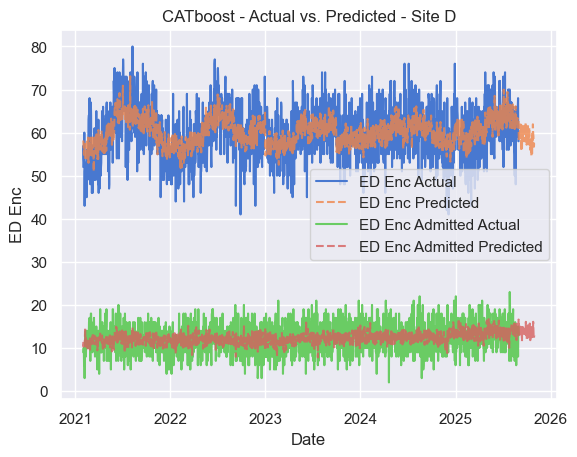

In [151]:
plot_df = siteD_real.with_columns(
    pl.datetime(
        pl.col("Year"),
        pl.col("Month"),
        pl.col("Day"),
    ).alias("Date")
).group_by("Date").agg(pl.col("ED Enc").sum(), pl.col("ED Enc Admitted").sum())

predict = siteD_catmodel.predict(predict_dates.to_pandas())
predict_df = predict_dates.with_columns(
    pl.Series(name="ED Enc Predicted", values=predict[:,0]),
    pl.Series(name="ED Enc Admitted Predicted", values=predict[:,1])
).with_columns(
    pl.datetime(
        pl.col("Year"),
        pl.col("Month"),
        pl.col("Day"),
    ).alias("Date")
).group_by("Date").agg(pl.col("ED Enc Predicted").sum(), pl.col("ED Enc Admitted Predicted").sum())

sns.lineplot(data=plot_df, x="Date", y="ED Enc", label="ED Enc Actual")
sns.lineplot(data=predict_df, x="Date", y="ED Enc Predicted", label="ED Enc Predicted", linestyle="--", alpha=0.8)
sns.lineplot(data=plot_df, x="Date", y="ED Enc Admitted", label="ED Enc Admitted Actual")
ax = sns.lineplot(data=predict_df, x="Date", y="ED Enc Admitted Predicted", label="ED Enc Admitted Predicted", linestyle="--", alpha=0.8)

ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
ax.set_title("CATboost - Actual vs. Predicted - Site D")
plt.show()

In [155]:
siteA_catmodel.save_model("./models/siteA_catmodel.json", format="json")
siteB_catmodel.save_model("./models/siteB_catmodel.json", format="json")
siteC_catmodel.save_model("./models/siteC_catmodel.json", format="json")
siteD_catmodel.save_model("./models/siteD_catmodel.json", format="json")

# ARIMA model
A popular model in forecasting time series data

In [152]:
import pmdarima as pm

siteA_data = df_hourly_blocks_pandas.loc[df_hourly_blocks_pandas["Site"] == "A"].drop("Site", axis=1)
model = pm.auto_arima(siteA_data["ED Enc"], seasonal=True, m=12, trace=True, error_action='ignore', suppress_warnings=True)

model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=32.22 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=73816.960, Time=0.11 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=60678.938, Time=2.47 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=8.74 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=73814.960, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=73034.799, Time=0.25 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=inf, Time=9.55 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=17.33 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=67590.430, Time=2.79 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=32.26 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=63329.790, Time=1.89 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=59216.347, Time=4.23 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=68378.410, Time=0.35 sec
 ARIMA(2,1,0)(2,0,0)[12] intercept   : AIC=inf, Time=13.76 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                11200
Model:             SARIMAX(4, 1, 0)x(2, 0, 0, 12)   Log Likelihood              -27563.866
Date:                            Fri, 13 Feb 2026   AIC                          55141.732
Time:                                    09:38:34   BIC                          55192.997
Sample:                                01-01-2018   HQIC                         55158.988
                                     - 08-31-2025                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7964      0.009    -85.278      0.000      -0.815      -0.778
ar.L2         -0.6514      0.012    -55.161      0.000      -0.675      -0.628
ar.L3         -0.4563      0.011    -41.024      0.000      -0.478      -0.434
ar.L4         -0.1811      0.009    -19.588      0.000      -0.199      -0.163
ar.S.L12       0.3988      0.007     53.494      0.000       0.384       0.413
ar.S.L24       0.4206      0.008     55.401      0.000       0.406       0.436
sigma2         8.0324      0.088     91.452      0.000       7.860       8.205
===================================================================================
Ljung-Box (L1) (Q):                   4.94   Jarque-Bera (JB):              1035.78
Prob(Q):                              0.03   Prob(JB):                         0.00
Heteroskedasticity (H):               0.93   Skew:                            -0.52
Prob(H) (two-sided):                  0.03   Kurtosis:                         4.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [153]:
from pmdarima import model_selection

model_cv_scores = model_selection.cross_val_score(
    model, siteA_data["ED Enc"], scoring="mean_squared_error"
)

print(f"Model CV Scores: {model_cv_scores.tolist()}")
print(f"Average mean squared error: {model_cv_scores.mean()}")


Caching the list of root modules, please wait!
(This will only be done once - type '%rehashx' to reset cache!)


Caching the list of root modules, please wait!
(This will only be done once - type '%rehashx' to reset cache!)

This is taking too long, we give up.

This is taking too long, we give up.



KeyboardInterrupt: 

In [ ]:
from datetime import date, timedelta
date_range = pl.datetime_range(
    start=pl.lit(date(2021, 2, 1)),
    end=df["Date"].max(),
    interval=timedelta(hours=6),
    eager=True
)

date_range

literal
datetime[μs]
2021-02-01 00:00:00
2021-02-01 06:00:00
2021-02-01 12:00:00
2021-02-01 18:00:00
2021-02-02 00:00:00
…
2025-08-30 00:00:00
2025-08-30 06:00:00
2025-08-30 12:00:00


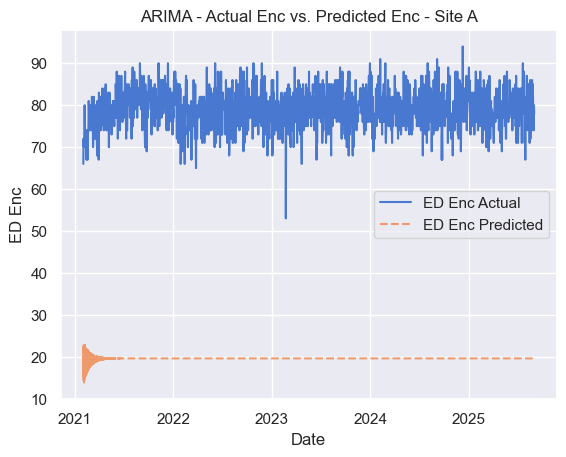

In [ ]:
plot_df = siteA_real.with_columns(
    pl.datetime(
        pl.col("Year"),
        pl.col("Month"),
        pl.col("Day"),
    ).alias("Date")
).group_by("Date").agg(pl.col("ED Enc").sum(), pl.col("ED Enc Admitted").sum())

predict = model.predict(n_periods=len(date_range))
predict_df = pl.DataFrame([date_range.alias("Date")]).with_columns(
    pl.Series(name="ED Enc Predicted", values=predict.tolist()),
    pl.Series(name="ED Enc Admitted Predicted", values=predict.tolist())
)

sns.lineplot(data=plot_df, x="Date", y="ED Enc", label="ED Enc Actual")
ax = sns.lineplot(data=predict_df, x="Date", y="ED Enc Predicted", label="ED Enc Predicted", linestyle="--", alpha=0.8)

ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
ax.set_title("ARIMA - Actual Enc vs. Predicted Enc - Site A")
plt.show()